In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from imblearn.over_sampling import RandomOverSampler
import lime.lime_tabular
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
config_file = open('config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"]

In [3]:
config_file = open('visual_config.json')
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

# Get Dataset

In [4]:
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 

# data (as pandas dataframes) 
X = myocardial_infarction_complications.data.features 
y = myocardial_infarction_complications.data.targets 

  
# metadata 
print(myocardial_infarction_complications.metadata) 
  
# variable information 
print(myocardial_infarction_complications.variables) 

{'uci_id': 579, 'name': 'Myocardial infarction complications', 'repository_url': 'https://archive.ics.uci.edu/dataset/579/myocardial+infarction+complications', 'data_url': 'https://archive.ics.uci.edu/static/public/579/data.csv', 'abstract': 'Prediction of myocardial infarction complications', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1700, 'num_features': 111, 'feature_types': ['Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK', 'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C53P5M', 'creators': ['S.E. Golovenkin', 'V.A. Shulman', 'D.A. Rossiev', 'P.A. Shesternya', 'S.Yu. Nikulina', 'Yu.V. Orlova', 'V.F. Voino-Yasenetsky'], 'intro_paper': {'tit

In [5]:
y = y["LET_IS"]
y = y.to_numpy()

In [6]:
data_analysis = DatasetAnalysis()

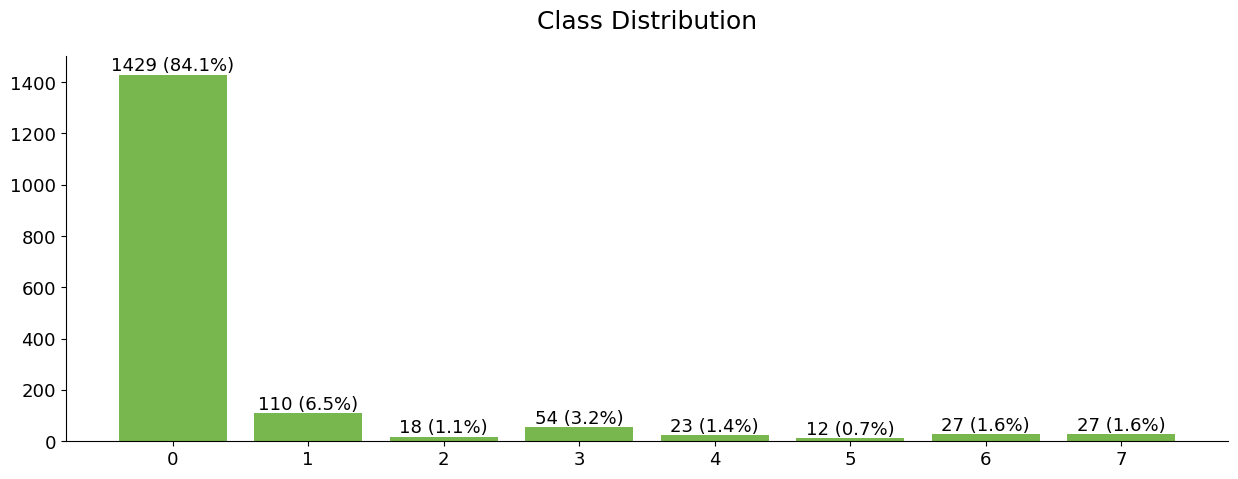

In [8]:
plt.figure(figsize=(15, 5))

data_analysis.class_dist(y, title="Class Distribution", colors=green_color, label_font_size=label_size)

plt.savefig(f"{logs_dir}/myocardial_class_dist.png", bbox_inches="tight")
plt.show()

In [194]:
X.shape

(1700, 111)

In [195]:
# y = [y.columns[x] for x in np.argmax(y, axis=1)]
# np.unique(y, return_counts=True)

In [199]:
imputer = KNNImputer(n_neighbors=10)
X = imputer.fit_transform(X)
imputer.get_feature_names_out()

array(['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST',
       'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A', 'nr_11',
       'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01',
       'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01',
       'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03',
       'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG',
       'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST',
       'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im',
       'post_im', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02',
       'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08',
       'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04',
       'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09',
       'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04',
       'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08',
       'n_p

## Binary Classification

In [200]:
#Transform multiclass classification in binary classification
y_bin = [0 if x == 0 else 1 for x in y]

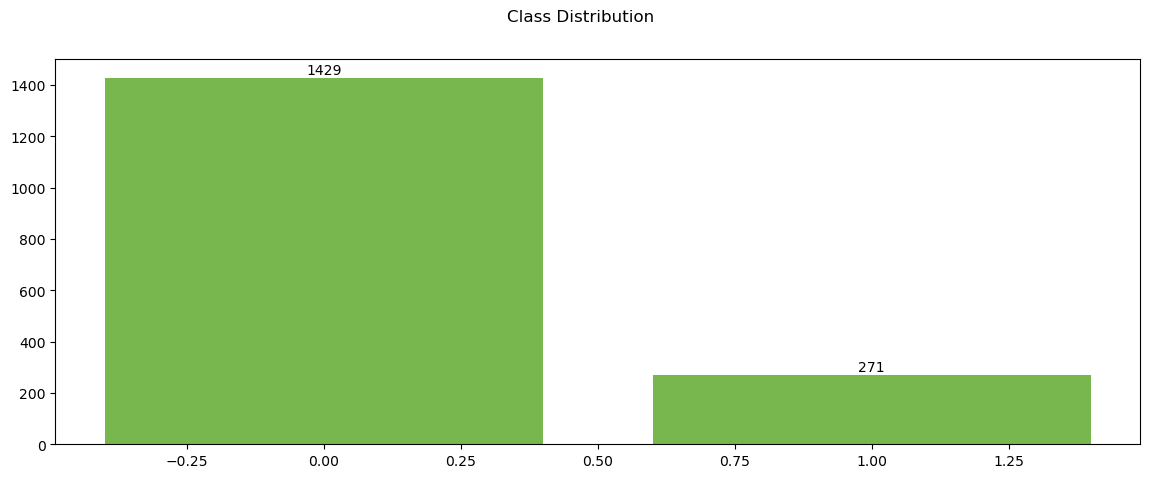

In [201]:
classes_bin = np.unique(y_bin, return_counts=True)
class_dist(classes_bin)

We can see that even adding all the classes that represent some form of disease, there is still a great difference between samples of the positive class and of the negative

In [202]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_bin, test_size=0.33, random_state=42)
features_names = imputer.get_feature_names_out()
X_train_pd = pd.DataFrame(X_train, columns=features_names)
X_test_pd = pd.DataFrame(X_test, columns=features_names)

In [203]:
print(f"DImensões do treino:  {X_train_pd.shape}")
print(f"Dimensões do teste:  {X_test_pd.shape}")

DImensões do treino:  (1139, 111)
Dimensões do teste:  (561, 111)


## Class distribution on the train split

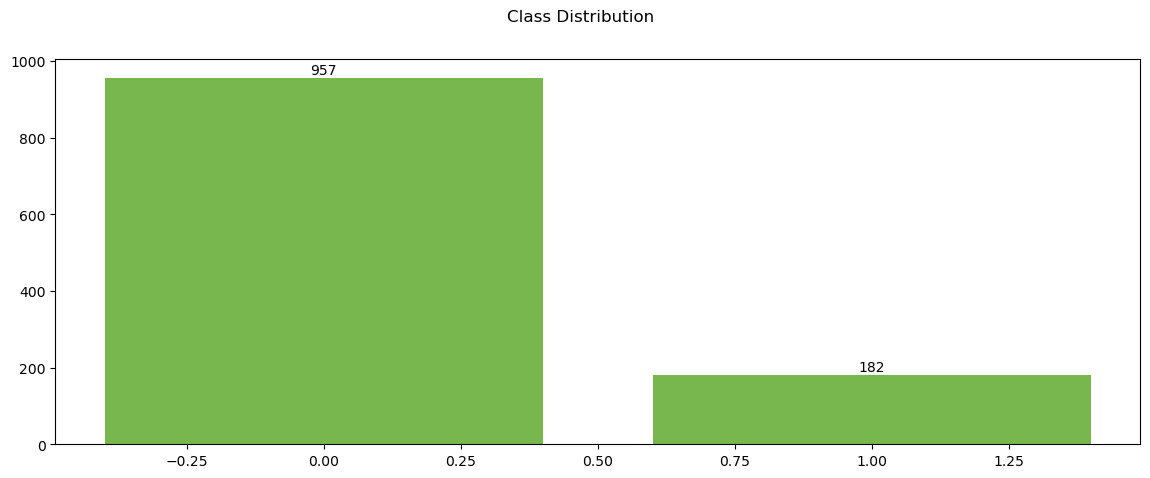

In [204]:
class_dist(np.unique(Y_train, return_counts=True))

## Class distribution on the test split

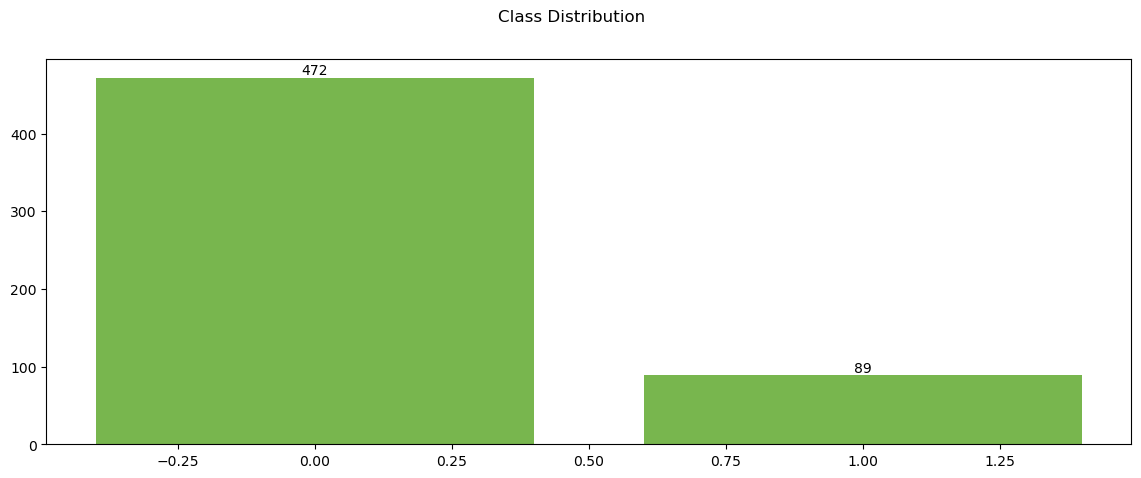

In [205]:
class_dist(np.unique(Y_test, return_counts=True))

## Pre-Processing

It seems that the class of '0', which represents absence of complications, is much more numerous than the others, this can decrease the accuracy of the classifier on the other classes as well as the overall performance. So it is advisable to do a pre-processing that make the number of examples of all classes more or less even. That can be done with <i>undersampling</i> and <i>oversampling</i>

In [206]:
# from imblearn.under_sampling import RandomUnderSampler
# from collections import Counter
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)
ros = RandomOverSampler(random_state=0)
X_bin, y_bin = ros.fit_resample(X, y_bin)

In [207]:
np.unique(X_bin, return_counts=True)

(array([0.0e+00, 3.0e-02, 4.0e-02, ..., 2.3e+02, 2.4e+02, 2.6e+02]),
 array([228527,      1,     36, ...,      3,     12,      8], dtype=int64))

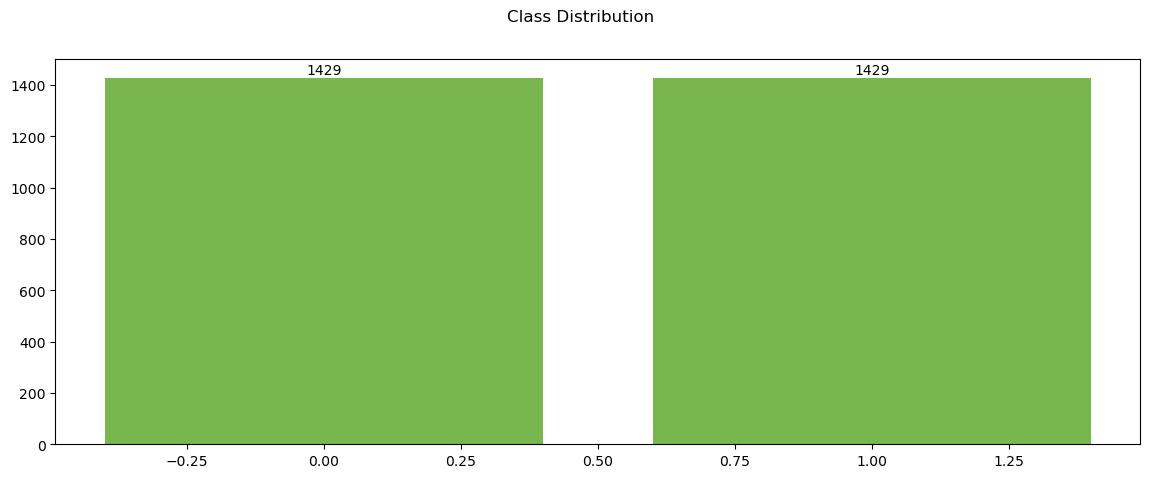

In [208]:
class_dist(np.unique(y_bin, return_counts=True))

In [209]:
X_train, X_test, Y_train, Y_test = train_test_split(X_bin, y_bin, test_size=0.33, random_state=42)
features_names = imputer.get_feature_names_out()
X_train_pd = pd.DataFrame(X_train, columns=features_names)
X_test_pd = pd.DataFrame(X_test, columns=features_names)

In [210]:
print(f"Dimensões do treino:  {X_train_pd.shape}")
print(f"Dimensões do teste:  {X_test_pd.shape}")

Dimensões do treino:  (1914, 111)
Dimensões do teste:  (944, 111)


# Classification


## Train the Model - <i>Logistic Regression</i> (LR)

In [211]:
lr_clf = LogisticRegression(max_iter=10000).fit(X_train, Y_train)

Score: 83.05084745762711%


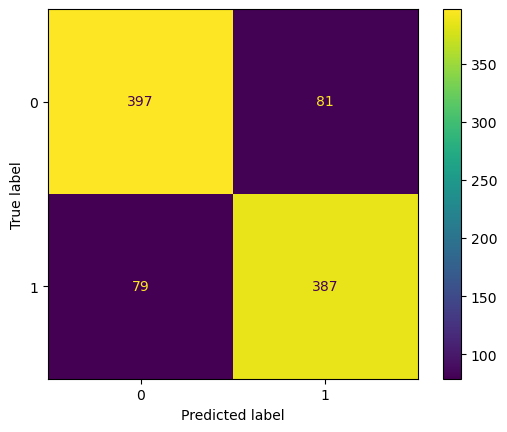

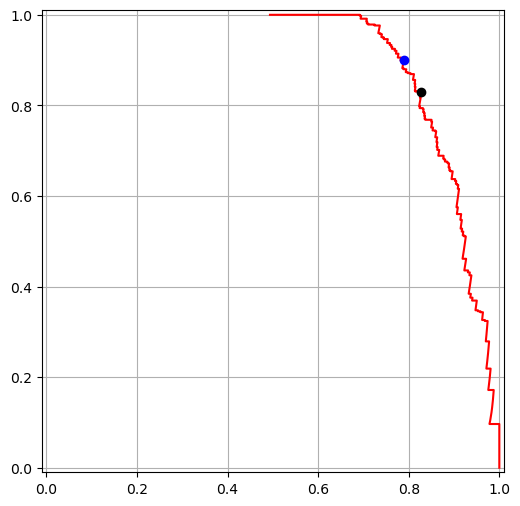

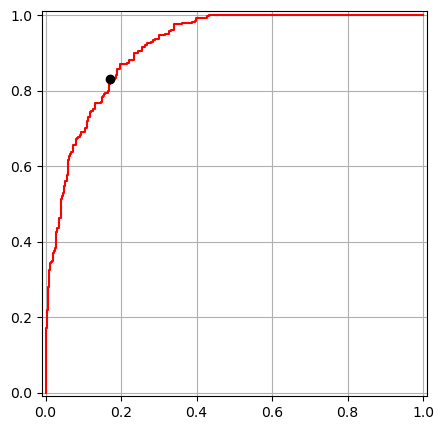

In [212]:
lr_ye = lr_clf.predict(X_test)
lr_cm = confusion_matrix(Y_test, lr_ye)

print(f"Score: {(1 - ((np.sum(lr_ye != Y_test)/len(Y_test)))) * 100}%")

lr_cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm)
lr_cm_display.plot()

lr_y2d = lr_clf.predict_proba(X_test)[:, 1]
plot_PR(Y_test, lr_cm, lr_y2d)
plot_ROC(Y_test, lr_cm, lr_y2d)

In [213]:
compute_metrics(lr_cm)

Metrics                Values
accuracy             0.830508
false-positive rate  0.169456
false-negative rate  0.169528
precision            0.826923
recall               0.830472
f-score              0.828694

In [214]:
print(f"Instância:\n {X_test[0, :]}\n\nClasse: {Y_test[0]}")

Instância:
 [7.30e+01 1.00e+00 3.00e+00 6.00e+00 2.00e+00 2.00e+00 3.00e-01 2.00e+00
 0.00e+00 7.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 1.50e+02 9.00e+01 8.00e+01 5.00e+01 1.00e+00 1.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 4.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 1.00e+00 2.30e+00 0.00e+00 1.39e+02 4.03e-01 2.08e-01 2.00e+00
 6.60e+00 3.10e+01 2.00e+00 1.00e+00 2.00e+00 1.00e-01 1.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.

## Extract Explanations

### <i>Local Model-Agnostic Explanations</i> (LIME)

In [215]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(X_test[0], lr_clf.predict_proba)

In [216]:
lr_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [217]:
shap.initjs()

In [218]:
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 10))
lr_shap_values = np.array(lr_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [219]:
lr_shap_values.shape, lr_SHAP_exp.expected_value.shape

((111, 2), (2,))

In [220]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_values[:,1], X_test_pd.iloc[0, :])

### SHAP Global

In [221]:
lr_shap_values = np.array(lr_SHAP_exp.shap_values(X_test_pd))
shap.summary_plot(lr_shap_values[:,:,1], X_test_pd, plot_type="bar")

## Train the Model - <i>Random Forest</i> (RF)

In [222]:
rf_clf = RandomForestClassifier().fit(X_train, Y_train)

Score: 97.5635593220339%


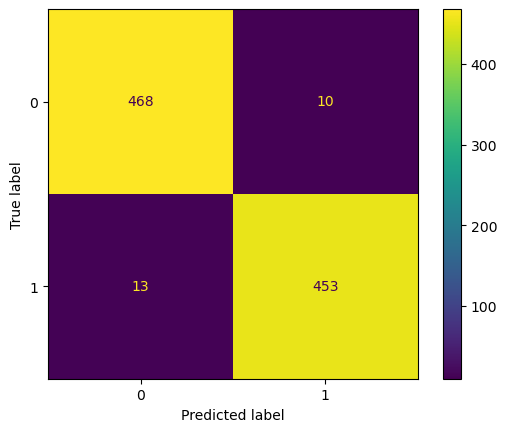

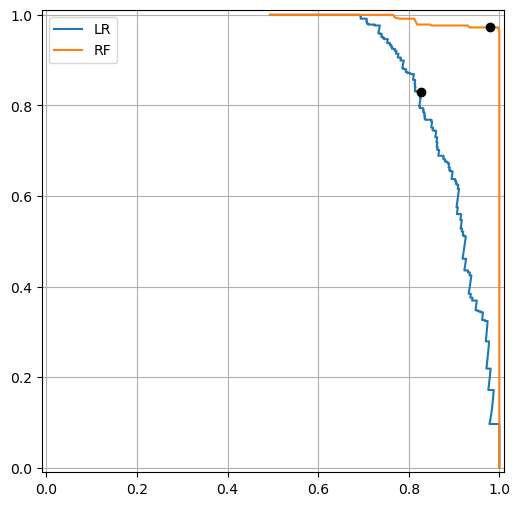

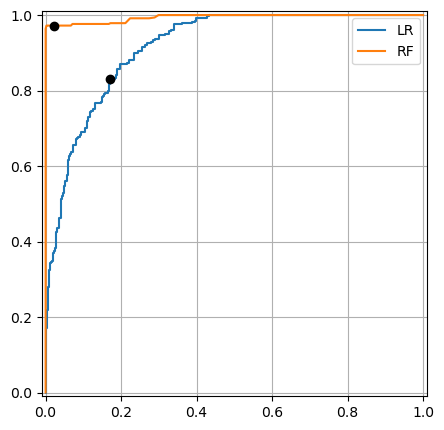

In [223]:
rf_ye = rf_clf.predict(X_test)
rf_cm = confusion_matrix(Y_test, rf_ye)

print(f"Score: {(1 - ((np.sum(rf_ye != Y_test)/len(Y_test)))) * 100}%")

rf_cm_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm)
rf_cm_display.plot()


rf_y2d = rf_clf.predict_proba(X_test)[:, 1]
compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])
compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])

## Extract Explanations


### <i>Local Model-Agnostic Explanations</i> (LIME)

In [224]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(X_test[0], rf_clf.predict_proba)

In [225]:
rf_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [226]:
rf_SHAP_exp = shap.KernelExplainer(rf_clf.predict_proba, shap.sample(X_train_pd, 10))
rf_shap_values = np.array(rf_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [227]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_values[:,1], X_test_pd.iloc[0, :])

### SHAP Global

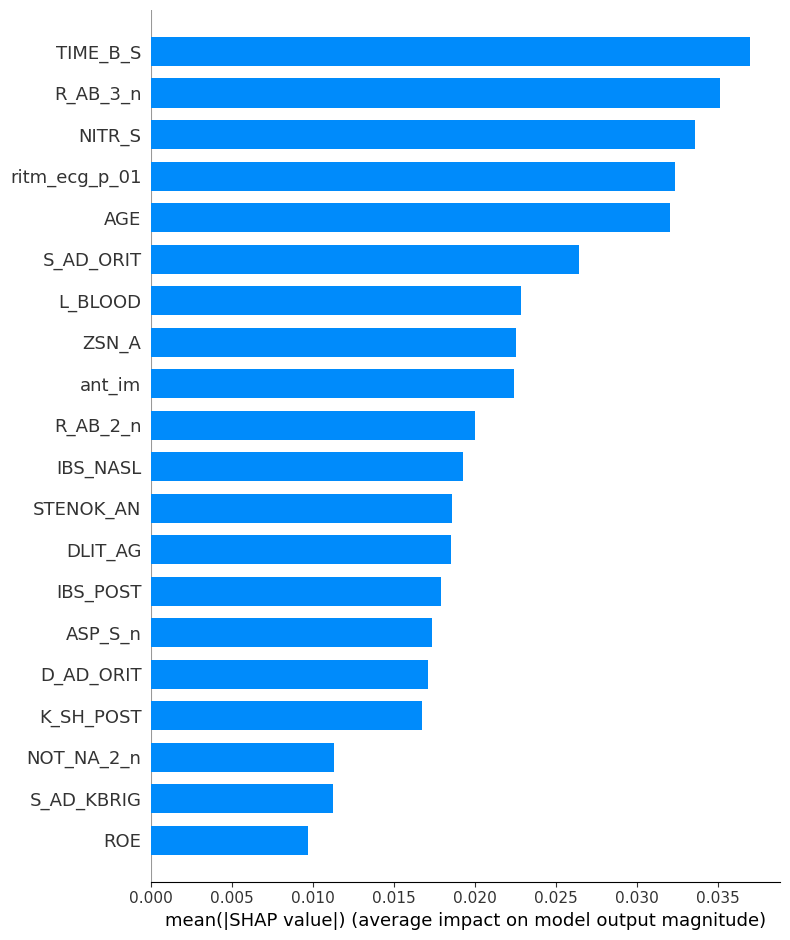

In [228]:
explainer = shap.Explainer(rf_clf)
rf_shap_values = explainer.shap_values(X_test_pd)
shap.summary_plot(rf_shap_values[:,:,1], X_test_pd, plot_type="bar")

In [229]:
# for var_name in features_names:
#     shap.dependence_plot(var_name, rf_shap_values[1], X_test_pd, feature_names=features_names)

# Train SVM

In [230]:
svm_clf = SVC(kernel="linear", probability=True).fit(X_train, Y_train)

Score: 82.62711864406779%


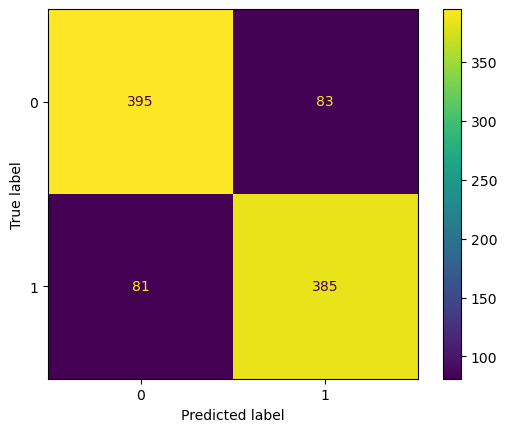

In [231]:
svm_ye = svm_clf.predict(X_test)
svm_cm = confusion_matrix(Y_test, svm_ye)

print(f"Score: {(1 - ((np.sum(svm_ye != Y_test)/len(Y_test)))) * 100}%")

svm_cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm)
svm_cm_display.plot()
# svm_y2d = svm_clf.decision_function(X_test)
# compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])
# compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])
# print(svm_y2d)

## Extract Explanations


### <i>Local Model-Agnostic Explanations</i> (LIME)

In [232]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(X_test[0], svm_clf.predict_proba)

In [233]:
svm_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [234]:
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 10))
svm_shap_values = np.array(svm_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [235]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_values[:,1], X_test_pd.iloc[0, :])

### SHAP Global

In [236]:
# svm_shap_values = np.array(svm_SHAP_exp.shap_values(X_test_pd))
# shap.summary_plot(svm_shap_values[:,:,1], X_test_pd, plot_type="bar")

## <i>Train Explainable Boosting Machine</i> (EBM)

Score: 95.97457627118644%


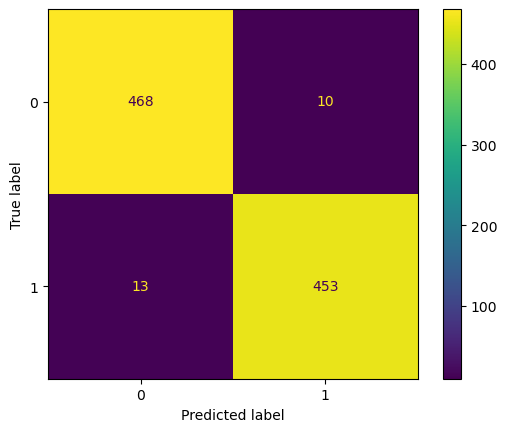

In [237]:
ebm_clf = ExplainableBoostingClassifier()
ebm_clf.fit(X_train_pd, Y_train)

ebm_ye = ebm_clf.predict(X_test)
ebm_cm = confusion_matrix(Y_test, rf_ye)

print(f"Score: {(1 - ((np.sum(ebm_ye != Y_test)/len(Y_test)))) * 100}%")

ebm_cm_display = ConfusionMatrixDisplay(confusion_matrix = ebm_cm)
ebm_cm_display.plot()

### Extract Explanations

### Global

In [238]:
ebm_global = ebm_clf.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2293612640912/ -->

# Multiclass Classification

In this step we pretend to distinguish the different diseases of the patient, to achieve this goal it is just considered the positive labels

In [239]:
X_multi = X[y > 0, :]
y_multi = y[y > 0]
print(y.shape, y_multi.shape, X.shape, X_multi.shape)

(1700,) (271,) (1700, 111) (271, 111)


## Class distribution on the train split

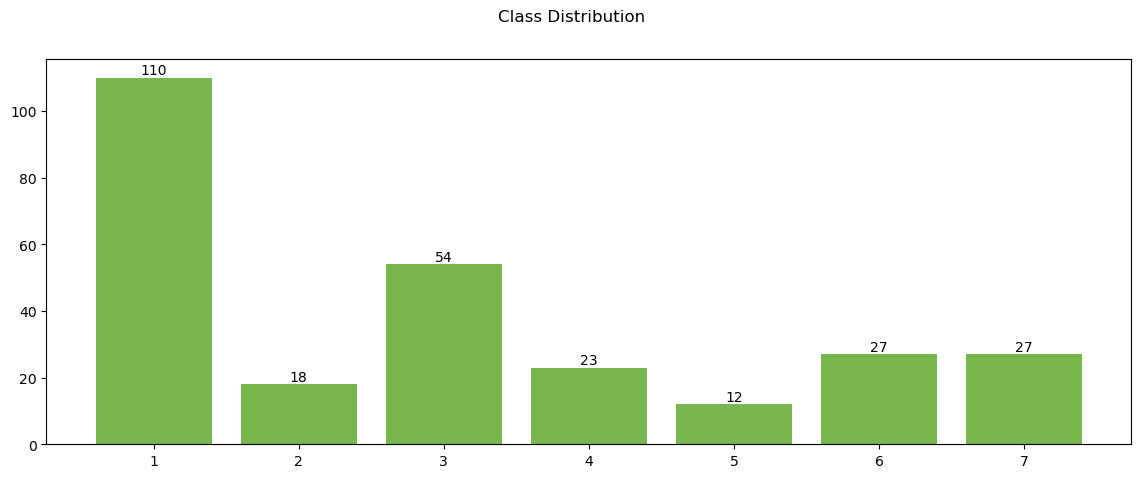

In [240]:
class_dist(np.unique(y_multi, return_counts=True))

In [241]:
# from imblearn.under_sampling import RandomUnderSampler
# from collections import Counter
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)
ros = RandomOverSampler(random_state=0)
X_multi, y_multi = ros.fit_resample(X_multi, y_multi)

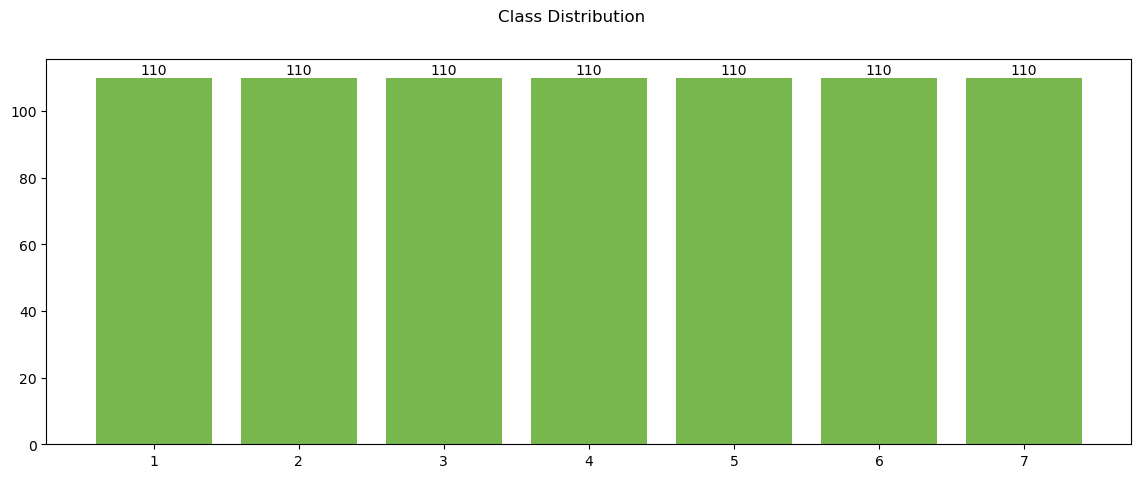

In [242]:
class_dist(np.unique(y_multi, return_counts=True))

In [243]:
X_train, X_test, Y_train, Y_test = train_test_split(X_multi, y_multi, test_size=0.33, random_state=42)
features_names = imputer.get_feature_names_out()
X_train_pd = pd.DataFrame(X_train, columns=features_names)
X_test_pd = pd.DataFrame(X_test, columns=features_names)

# Classification


## Train the Model - <i>Logistic Regression</i> (LR)

In [244]:
lr_clf = LogisticRegression(solver="lbfgs", max_iter=10000).fit(X_train, Y_train)

C:\Users\alexv.DESKTOP-H277D4D\Anaconda3\envs\envXAIV2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Score: 79.6078431372549%


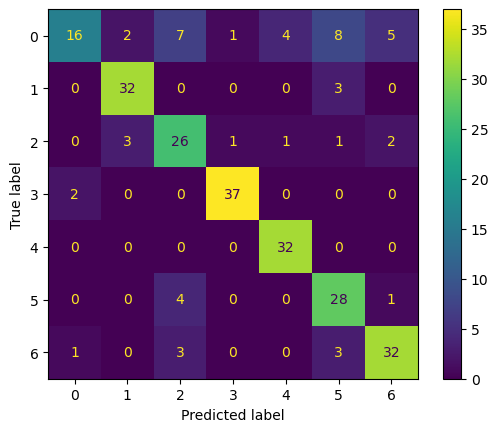

In [245]:
lr_ye = lr_clf.predict(X_test)
lr_cm = confusion_matrix(Y_test, lr_ye)

print(f"Score: {(1 - ((np.sum(lr_ye != Y_test)/len(Y_test)))) * 100}%")

lr_cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm)
lr_cm_display.plot()

## Extract Explanations

### <i>Local Model-Agnostic Explanations</i> (LIME)

In [246]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(X_test[0], lr_clf.predict_proba)

In [247]:
lr_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [248]:
shap.initjs()

In [249]:
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 10))
lr_shap_values = np.array(lr_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [250]:
lr_shap_values.shape, lr_SHAP_exp.expected_value.shape

((111, 7), (7,))

In [251]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_values[:,1], X_test_pd.iloc[0, :])

### SHAP Global

In [252]:
# lr_shap_values = np.array(lr_SHAP_exp.shap_values(X_test_pd))
# shap.summary_plot(lr_shap_values[:,:,1], X_test_pd, plot_type="bar")

## Train the Model - <i>Random Forest</i> (RF)

In [253]:
rf_clf = RandomForestClassifier().fit(X_train, Y_train)

Score: 91.37254901960785%


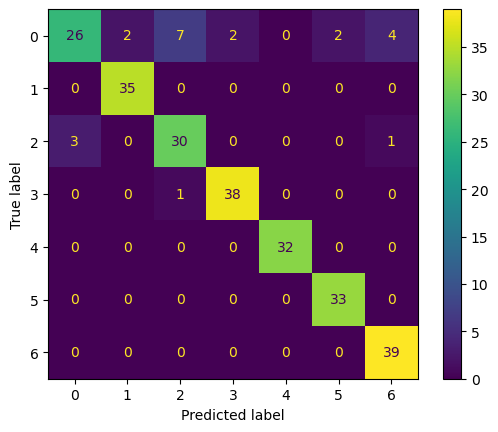

In [254]:
rf_ye = rf_clf.predict(X_test)
rf_cm = confusion_matrix(Y_test, rf_ye)

print(f"Score: {(1 - ((np.sum(rf_ye != Y_test)/len(Y_test)))) * 100}%")

rf_cm_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm)
rf_cm_display.plot()


# rf_y2d = rf_clf.predict_proba(X_test)[:, 1]
# compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])
# compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])

## Extract Explanations


### <i>Local Model-Agnostic Explanations</i> (LIME)

In [255]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(X_test[0], rf_clf.predict_proba)

In [256]:
rf_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [257]:
rf_SHAP_exp = shap.KernelExplainer(rf_clf.predict_proba, shap.sample(X_train_pd, 10))
rf_shap_values = np.array(rf_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [258]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_values[:,1], X_test_pd.iloc[0, :])

### SHAP Global

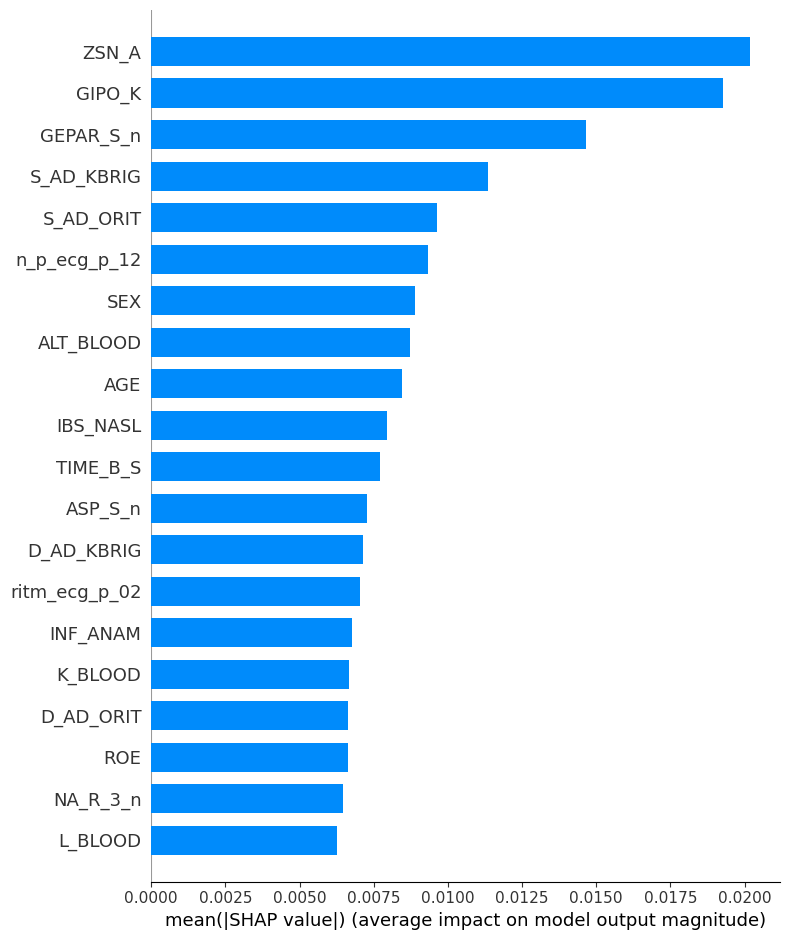

In [259]:
explainer = shap.Explainer(rf_clf)
rf_shap_values = explainer.shap_values(X_test_pd)
shap.summary_plot(rf_shap_values[:,:,1], X_test_pd, plot_type="bar")

# Train SVM

In [260]:
svm_clf = SVC(probability=True, kernel="linear").fit(X_train, Y_train)

Score: 87.05882352941177%


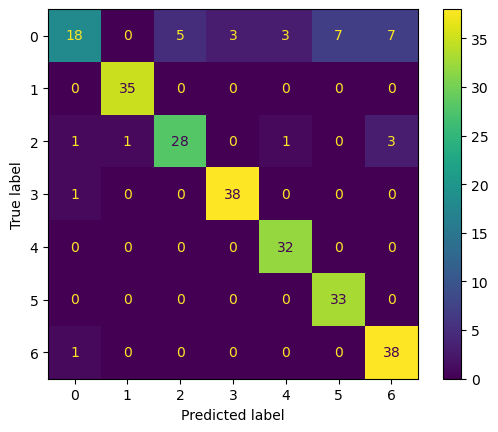

In [261]:
svm_ye = svm_clf.predict(X_test)
svm_cm = confusion_matrix(Y_test, svm_ye)

print(f"Score: {(1 - ((np.sum(svm_ye != Y_test)/len(Y_test)))) * 100}%")

svm_cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm)
svm_cm_display.plot()
# svm_y2d = svm_clf.decision_function(X_test)
# compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])
# compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])
# print(svm_y2d)

## Extract Explanations


### <i>Local Model-Agnostic Explanations</i> (LIME)

In [262]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(X_test[0], svm_clf.predict_proba)

In [263]:
svm_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [264]:
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 10))
svm_shap_values = np.array(svm_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [265]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_values[:,1], X_test_pd.iloc[0, :])

## <i>Train Explainable Boosting Machine</i> (EBM)

C:\Users\alexv.DESKTOP-H277D4D\Anaconda3\envs\envXAIV2\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.



Score: 86.66666666666667%


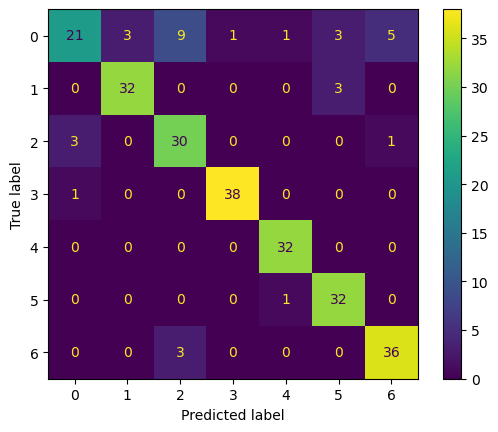

In [266]:
ebm_clf = ExplainableBoostingClassifier()
ebm_clf.fit(X_train_pd, Y_train)

ebm_ye = ebm_clf.predict(X_test)
ebm_cm = confusion_matrix(Y_test, ebm_ye)

print(f"Score: {(1 - ((np.sum(ebm_ye != Y_test)/len(Y_test)))) * 100}%")

ebm_cm_display = ConfusionMatrixDisplay(confusion_matrix = ebm_cm)
ebm_cm_display.plot()

### Extract Explanations

### Global

In [267]:
ebm_global = ebm_clf.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2293539666576/ -->

### SHAP Global

In [268]:
# svm_shap_values = np.array(svm_SHAP_exp.shap_values(X_test_pd))
# shap.summary_plot(svm_shap_values[:,:,1], X_test_pd, plot_type="bar")

#### Explain first test instance for each class

In [269]:
# for i in range(len(np.unique(Y_train))):
#     print(f"Class {i}")
#     shap.force_plot(lr_SHAP_exp.expected_value[i], lr_shap_values[i,:], X_test_pd.iloc[0, :], matplotlib=True)